In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

### importing data

In [2]:
run_qs = RunStats.objects.filter(psearch__id=89, method="BD", status=3)

pd.DataFrame.from_dict(run_qs.values('run_id', 'coherence', 'exclusivity', 'K', 'alpha',
                                'top_chain_var', 'rng_seed', 'max_iter'))

,K,alpha,coherence,exclusivity,max_iter,rng_seed,run_id,top_chain_var
0,35,0.01,0.419955,0.804016,200,1,2350,0.010
1,40,0.01,0.396576,0.730940,200,1,2354,0.050
2,45,0.01,0.480687,0.928956,200,1,2352,0.010
3,45,0.05,0.473385,0.912385,50,1,2156,0.010
4,45,0.01,0.464178,0.878157,50,1,2155,0.010
5,45,0.01,0.511302,0.690445,50,1,2158,0.005
6,45,0.10,0.482888,0.901765,50,1,2157,0.010
7,45,0.05,0.415776,0.848308,50,1,2167,0.050
8,45,0.05,0.491613,0.746280,50,1,2160,0.005
9,45,0.01,0.400095,0.863986,50,1,2166,0.050


In [3]:
run_id = 2350

save_dir = "./plots/topic_analysis_{}".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

dts = DocTopic.objects.filter(run_id=run_id)
# total score of all DocTopics
print(dts.aggregate(
    n = Sum('score')
))
# total score of DocTopics, sorted by topic
pd.DataFrame.from_dict(list(dts.values('topic__id', 'topic__title').annotate(
    totalscore = Sum('score')
).order_by('-totalscore')))

{'n': 3933832.45000198}


,topic__id,topic__title,totalscore
0,184089,common terms,419821.116446
1,184090,procedural,367744.157874
2,184081,economic policy,216063.202495
3,184105,federal government,158838.262969
4,184102,policy statements,156957.446933
5,184106,budget,148827.974002
6,184086,European Coal & Steel Community,144982.504003
7,184098,international cooperation,142685.511866
8,184108,energy supply mix,134634.299691
9,184097,procedural 2,124332.949316


# party proportions aggregate over time

In [4]:
parlperiod_limit_begin = 12
parlperiod_limit_end = 19
doc_scores_party = pm.Utterance.objects.filter(
    doctopic__topic__run_id=run_id, 
    speaker__party__name__isnull=False,
    speaker__party__colour__isnull=False,
    document__parlperiod__n__isnull=False,
    document__parlperiod__n__gte=parlperiod_limit_begin,
    document__parlperiod__n__lte=parlperiod_limit_end
).order_by().values('doctopic__score',
                    'doctopic__topic__title',
                    'speaker__party__name')

dft = pd.DataFrame.from_dict(doc_scores_party)
# to carry on other properties:
#dft.groupby(['doctopic__topic__id', 'speaker__party__name']).agg({'topic_score': 'sum', 'speaker__party__id': 'last'})
dft_scores = dft.groupby(['doctopic__topic__title', 'speaker__party__name']).sum().unstack()
dft_scores.columns = dft_scores.columns.droplevel()
dft_proportions = dft_scores / dft_scores.sum(0)

In [5]:
dft_proportions

speaker__party__name,afd,cducsu,fdp,gruene,linke,spd
doctopic__topic__title,,,,,,
European Coal & Steel Community,0.005708,0.010007,0.007594,0.007433,0.005845,0.010323
agricultural policy,0.001273,0.002883,0.001583,0.004064,0.001937,0.001818
budget,0.006349,0.030179,0.013460,0.009147,0.015063,0.023853
budget 2,0.002856,0.018690,0.017411,0.021406,0.011969,0.029381
climate protection,0.126476,0.048492,0.037663,0.113843,0.110399,0.061454
coal mining,0.000054,0.001757,0.001890,0.000728,0.001164,0.002633
coal policy & prices,0.001801,0.002260,0.001488,0.002357,0.003294,0.002935
common terms,0.119158,0.111666,0.097944,0.128967,0.094982,0.117212
debate government policy,0.193389,0.021155,0.026970,0.139481,0.098214,0.032732


In [6]:
dft_proportions.max()

speaker__party__name
afd       0.193389
cducsu    0.111666
fdp       0.105259
gruene    0.139481
linke     0.127209
spd       0.117212
dtype: float64

In [7]:
dft_proportions.sum()

speaker__party__name
afd       1.0
cducsu    1.0
fdp       1.0
gruene    1.0
linke     1.0
spd       1.0
dtype: float64

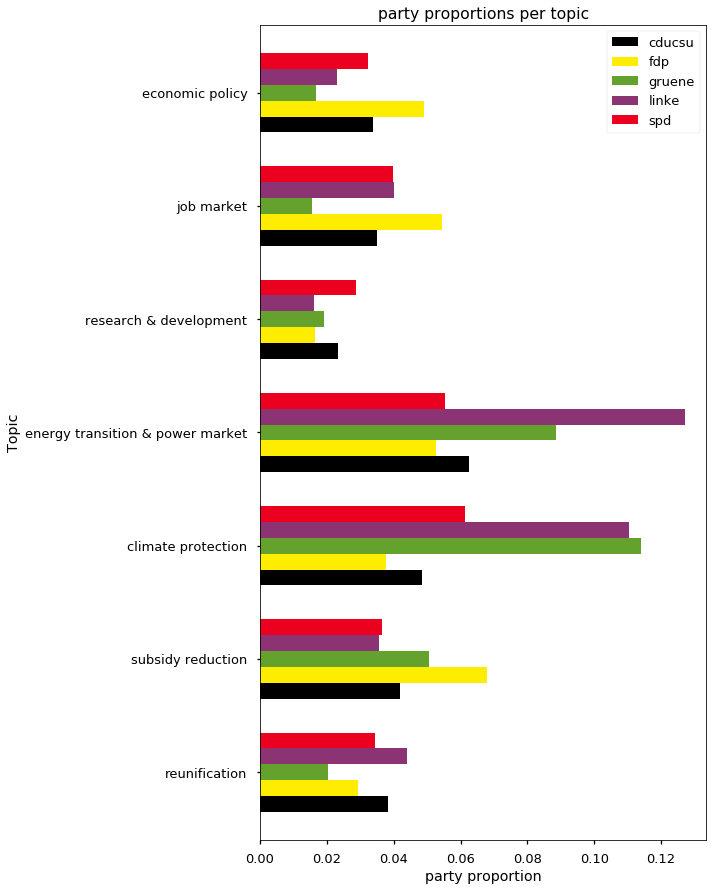

In [8]:
pct = False
stacked = False

#parties = ["cducsu", "fdp", "spd"]
parties = ["cducsu", "fdp", "gruene", "linke", "spd"]

party_color_dict = {"afd": "#0088FF", "cducsu": "#000000", "fdp": "#FFED00", "gruene": "#64A12D", "linke": "#8C3473", "spd": "#EB001F"}

party_color = [party_color_dict[party] for party in parties]

sns.set_palette(party_color)
sns.set_context('talk')

#topics = list(reversed(["agriculture", "coal mining industry", "diplomacy & trade",
#                 "east germany", "energy technology", "federal coal policy",
#                 "hard coal mining", "international climate protection", "nuclear phase out 2",
#                 "pollution control", "research & development", "subsidies", "taxes"]))

# for before 1990:
topics = ["European Coal and Steel Community", "coal policy & prices", "coal mining",
          "economic policy", "energy policy", "environmental protection"]

# for after 1990
topics = ["reunification", "subsidy reduction", "climate protection", "energy transition & power market",
          "research & development", "job market", "economic policy"]


dft_proportion = dft_proportions.loc[topics]

dft_proportion = dft_proportion[parties]

if pct:
    df_plot = dft_proportion.copy()
    for i in df_plot.index:
        df_plot.loc[i] = df_plot.loc[i] / df_plot.loc[i].sum() * 100
    xlabel = '% of party proportion'
    title_str = "Percentage of party proportions per topic"

else:
    xlabel = "party proportion"
    title_str = "party proportions per topic"
    df_plot = dft_proportion

ax = df_plot.plot.barh(stacked=stacked, # title=topic_names[0],
                 figsize=(8,15), width=0.7)

ax.set(xlabel=xlabel, ylabel='Topic', title=title_str)

if pct:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
else:
    plt.legend(title="")

filename = os.path.join(save_dir, "party_proportions_run_{}_before1990_selection".format(run_id))
plt.savefig(filename, dpi=300, bbox_inches="tight")

In [9]:
# the same for regions

# see also notebook topic_list_and_analysis_of_parties_and_regions

coal_regions = cmodels.Region.objects.filter(name__in=["Brandenburg", "North Rhine-Westphalia", "Saxony", "Saxony-Anhalt", "Saarland"])
non_coal_regions = cmodels.Region.objects.filter(name__in=["Baden-Württemberg", "Bavaria", "Berlin", "Bremen", "Hamburg", "Hesse",
                    "Mecklenburg-Vorpommern", "Lower Saxony", "Rheinland-Pfalz",
                    "Schleswig-Holstein", "Thuringia"])


index_to_keyword = {0: 'coal', 1: 'ncoal'}
dfs = {}

for j, regions in enumerate([coal_regions, non_coal_regions]):
    print(list(regions))

    scores_list_qs = pm.Utterance.objects.filter(
            doctopic__topic__run_id=run_id,
            speaker__seat__seat_type=2,
            speaker__seat__list__region__in=regions,
            document__parlperiod__n__gte=parlperiod_limit_begin,
            document__parlperiod__n__lte=parlperiod_limit_end
        ).distinct().order_by().values('doctopic__score', 'doctopic__topic__title')
    
    scores_list = pd.DataFrame.from_dict(scores_list_qs).groupby(['doctopic__topic__title']).sum().unstack()

    scores_direct_qs = pm.Utterance.objects.filter(
            doctopic__topic__run_id=run_id,
            speaker__seat__seat_type=1,
            speaker__seat__constituency__region__in=regions,
            document__parlperiod__n__gte=parlperiod_limit_begin,
            document__parlperiod__n__lte=parlperiod_limit_end
        ).distinct().order_by().values('doctopic__score', 'doctopic__topic__title')
    
    scores_direct = pd.DataFrame.from_dict(scores_direct_qs).groupby(['doctopic__topic__title']).sum().unstack()

    df = scores_list.to_frame(name='list').join(scores_direct.to_frame(name='direct'))
    df.index = df.index.droplevel()
    df['sum'] = df.sum(1)
    dfs[index_to_keyword[j]] = df
    
region_scores = pd.concat(dfs.values(), axis=1, keys=dfs.keys())
region_proportions = region_scores / region_scores.sum()

rp_clean = region_proportions.loc[:, (slice(None),'sum')]
rp_clean.columns = rp_clean.columns.droplevel(1)
rp_clean

[<Region: Brandenburg>, <Region: North Rhine-Westphalia>, <Region: Saarland>, <Region: Saxony>, <Region: Saxony-Anhalt>]
[<Region: Baden-Württemberg>, <Region: Bavaria>, <Region: Berlin>, <Region: Bremen>, <Region: Hamburg>, <Region: Hesse>, <Region: Lower Saxony>, <Region: Mecklenburg-Vorpommern>, <Region: Rheinland-Pfalz>, <Region: Schleswig-Holstein>, <Region: Thuringia>]


,coal,ncoal
doctopic__topic__title,,
European Coal & Steel Community,0.008020,0.009418
agricultural policy,0.001736,0.002938
budget,0.017430,0.029529
budget 2,0.019383,0.026197
climate protection,0.070831,0.053040
coal mining,0.003292,0.000819
coal policy & prices,0.002707,0.002176
common terms,0.115368,0.109075
debate government policy,0.034456,0.051961


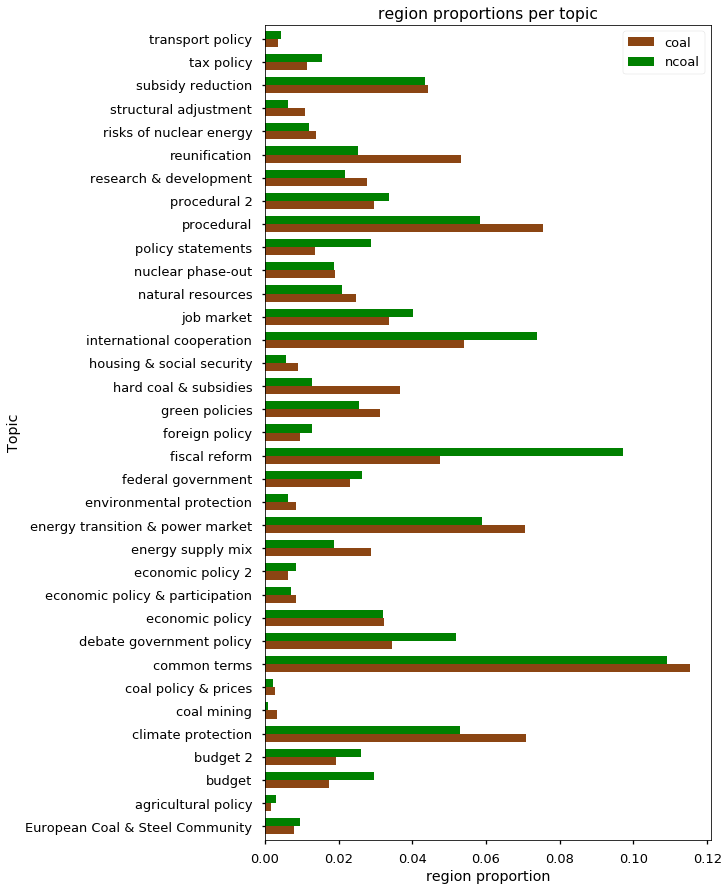

In [10]:
pct = False
stacked = False

# manual setting of colour, needs to be adjusted with new party or order change 
sns.set_palette(["saddlebrown", "green"])
sns.set_context('talk')

dft_proportion = rp_clean #.loc[topics]

if pct:
    df_plot = dft_proportion.copy()
    for i in df_plot.index:
        df_plot.loc[i] = df_plot.loc[i] / df_plot.loc[i].sum() * 100
    xlabel = '% of party proportion'
    title_str = "Percentage of party proportions per topic"

else:
    xlabel = "region proportion"
    title_str = "region proportions per topic"
    df_plot = dft_proportion

ax = df_plot.plot.barh(stacked=stacked, # title=topic_names[0],
                 figsize=(8,15), width=0.7)

ax.set(xlabel=xlabel, ylabel='Topic', title=title_str)

if pct:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
else:
    plt.legend(title="")

filename = os.path.join(save_dir, "region_proportions_run_{}_all".format(run_id))
plt.savefig(filename, dpi=300, bbox_inches="tight")

------------------------------------------------

# combine party and region proportions into one plot

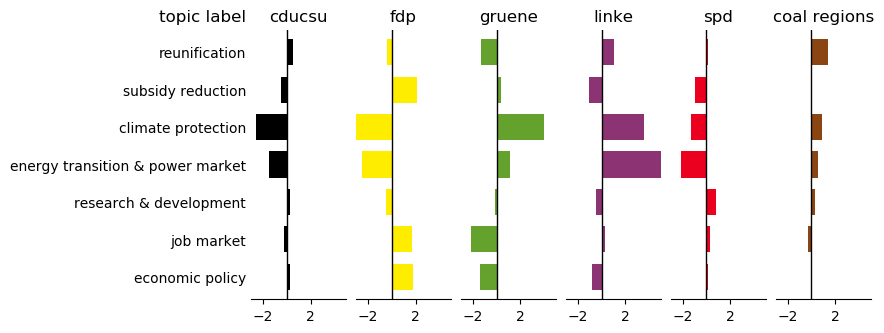

In [23]:
sns.reset_orig()

deviation = True
selection = True

parties = ["cducsu", "fdp", "gruene", "linke", "spd"]

# for after 1990
topics = ["job market", "fiscal reform", "research & development", "subsidy reduction", # economic topics
          "hard coal & subsidies", "energy transition & power market", # energy
          "green policies", "climate protection", "natural resources", # environment 
          "reunification", ""]

if selection:
    selected_topics = list(reversed(topics))
else:
    selected_topics = rp_clean.index

dft_proportions_selected = 100 * dft_proportions.loc[selected_topics]
rp_selected = 100 * rp_clean.loc[selected_topics]

if deviation:
    dft_proportions_selected = dft_proportions_selected.sub(dft_proportions_selected[parties].mean(1), axis=0)
    rp_selected = rp_selected.sub(rp_selected.mean(1), axis=0)

if deviation:
    fig, ax = plt.subplots(1, len(parties) + 1, sharey=True, figsize=(8, len(selected_topics)/2))

else:
    fig, ax = plt.subplots(1, len(parties) + 2, sharex=True, sharey=True, figsize=(10, 5))


# plot party proportions
for i, party in enumerate(parties):
    dft_proportions_selected[party].plot.barh(ax=ax[i], color = party_color[i], width=0.7)
    ax[i].set_ylabel('')
    ax[i].set_title(party)
    if deviation:
        ax[i].set_xlim([-3, 5])
        ax[i].set_xticks([-2, 2])
    
# plot region proportions

rp_selected['coal'].plot.barh(ax=ax[len(parties)], color = "saddlebrown", width=0.7)
ax[len(parties)].set_title('coal regions')
if deviation:
    ax[len(parties)].set_xlim([-3, 5])
    ax[len(parties)].set_xticks([-2, 2])


if not deviation:
    rp_selected['ncoal'].plot.barh(ax=ax[len(parties) + 1], color = "green", width=0.7)
    ax[len(parties) + 1].set_title('non coal')

for a in ax:
    #a.yaxis.set_visible(False) # Hide only x axis
    a.tick_params(axis='y', length=0, which='both')
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)
    a.spines["left"].set_visible(False)
    a.axvline(x=0, ymin=0, ymax=1, color='k', linewidth=1)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[0].text(-0.05, 1.048, 'topic label', horizontalalignment='right',
            verticalalignment='center', transform=ax[0].transAxes, fontsize=12)

if selection:
    filename = os.path.join(save_dir, "party_and_region_proportions_deviation_run_{}_from1990_selection".format(run_id))
else:
    filename = os.path.join(save_dir, "party_and_region_proportions_deviation_run_{}_from1990_all".format(run_id))

plt.savefig(filename, dpi=300, bbox_inches="tight")

# compress folder to easily download it

In [27]:
%%bash
zip -r plots/topic_analysis_2350.zip plots/topic_analysis_2350/

updating: plots/topic_analysis_2350/ (stored 0%)
updating: plots/topic_analysis_2350/0_topic_list_run2350_labeled.csv (deflated 70%)
updating: plots/topic_analysis_2350/0_topic_list+peak_topwords_run2350.xlsx (deflated 5%)
updating: plots/topic_analysis_2350/.ipynb_checkpoints/ (stored 0%)
updating: plots/topic_analysis_2350/topic_evolution_run2350_aggregate.png (deflated 8%)
updating: plots/topic_analysis_2350/party_proportions_run_2350_selection.png (deflated 30%)
updating: plots/topic_analysis_2350/topic_evolution_shares_run2350_wo_procedural_barplot_simple.png (deflated 19%)
updating: plots/topic_analysis_2350/topic_evolution_scores_run2350_all.png (deflated 10%)
updating: plots/topic_analysis_2350/topic_evolution_shares_run2350_all.png (deflated 9%)
updating: plots/topic_analysis_2350/time+party/ (stored 0%)
updating: plots/topic_analysis_2350/time+party/party_scores_run_2350_topic_184087.png (deflated 24%)
updating: plots/topic_analysis_2350/time+party/party_proportions_run_2350_